# Demo polars capabilities and interactively develop it

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import polars as pl
import seaborn as sns

from floris import tools as wfct
from floris.utilities import wrap_360


from flasc.energy_ratio import energy_ratio_suite
from flasc.energy_ratio_polars import energy_ratio_polars as erp

from flasc.visualization import plot_layout_with_waking_directions, plot_binned_mean_and_ci




### Use FLORIS to generate a wake steering data set

<Axes: xlabel='x coordinate (m)', ylabel='y coordinate (m)'>

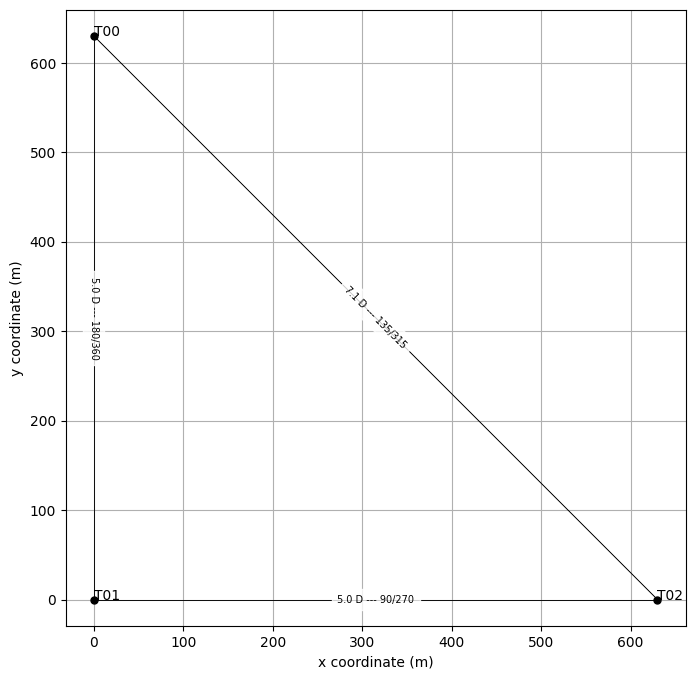

In [4]:


file_path = Path.cwd()
fi_path = file_path / "../../examples_artificial_data/demo_dataset/demo_floris_input.yaml"
fi = wfct.floris_interface.FlorisInterface(fi_path)
fi.reinitialize(layout_x = [0, 0, 5*126], layout_y = [5*126, 0, 0])

# # Show the wind farm
plot_layout_with_waking_directions(fi)



Num Points 16000


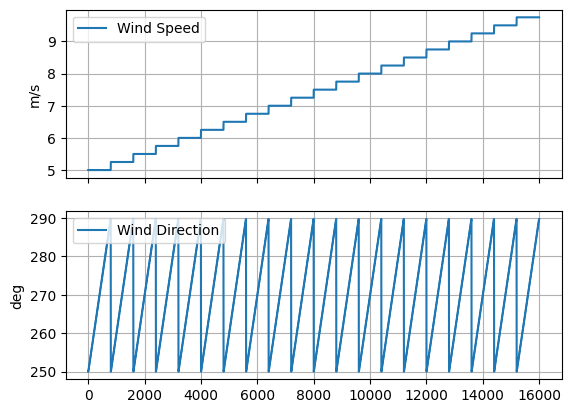

In [5]:
# Create a time history of points where the wind speed and wind direction step different combinations
ws_points = np.arange(5.0,10.0,0.25)
wd_points = np.arange(250.0, 290.0, 0.25,)
num_points_per_combination = 5 # 5 # How many "seconds" per combination

# I know this is dumb but will come back, can't quite work out the numpy version
ws_array = []
wd_array = []
for ws in ws_points:
    for wd in wd_points:
        for i in range(num_points_per_combination):
            ws_array.append(ws)
            wd_array.append(wd)
t = np.arange(len(ws_array))

print(f'Num Points {len(t)}')

fig, axarr = plt.subplots(2,1,sharex=True)
axarr[0].plot(t, ws_array,label='Wind Speed')
axarr[0].set_ylabel('m/s')
axarr[0].legend()
axarr[0].grid(True)
axarr[1].plot(t, wd_array,label='Wind Direction')
axarr[1].set_ylabel('deg')
axarr[1].legend()
axarr[1].grid(True)

In [6]:
# Compute the power of the second turbine for two cases
# Baseline: The front turbine is aligned to the wind
# WakeSteering: The front turbine is yawed 25 deg
fi.reinitialize(wind_speeds=ws_array, wind_directions=wd_array, time_series=True)
fi.calculate_wake()
power_baseline_ref = fi.get_turbine_powers().squeeze()[:,0].flatten() / 1000.
power_baseline_control = fi.get_turbine_powers().squeeze()[:,1].flatten() / 1000.
power_baseline_downstream = fi.get_turbine_powers().squeeze()[:,2].flatten() / 1000.

yaw_angles = np.zeros([len(t),1,3]) * 25
yaw_angles[:,:,1] = 25 # Set control turbine yaw angles to 25 deg
fi.calculate_wake(yaw_angles=yaw_angles)
power_wakesteering_ref = fi.get_turbine_powers().squeeze()[:,0].flatten() / 1000.
power_wakesteering_control = fi.get_turbine_powers().squeeze()[:,1].flatten() /1000.
power_wakesteering_downstream = fi.get_turbine_powers().squeeze()[:,2].flatten() /1000.

## Pandas version (for time)

In [7]:
# Build up the data frames needed for energy ratio suite
df_baseline_pd = pd.DataFrame({
    'wd':wd_array,
    'ws':ws_array,
    'pow_ref':power_baseline_ref,
    'pow_000':power_baseline_ref, 
    'pow_001':power_baseline_control,
    'pow_002':power_baseline_downstream
})

df_wakesteering_pd = pd.DataFrame({
    'wd':wd_array,
    'ws':ws_array,
    'pow_ref':power_wakesteering_ref,
    'pow_000':power_wakesteering_ref, 
    'pow_001':power_wakesteering_control,
    'pow_002':power_wakesteering_downstream
})

# Create alternative versions of each of the above dataframes where the wd/ws are perturbed by noise
df_baseline_noisy_pd = pd.DataFrame({
    'wd':wd_array + np.random.randn(len(wd_array))*5,
    'ws':ws_array + np.random.randn(len(ws_array)),
    'pow_ref':power_baseline_ref,
    'pow_000':power_baseline_ref, 
    'pow_001':power_baseline_control,
    'pow_002':power_baseline_downstream
})

df_wakesteering_noisy_pd = pd.DataFrame({
    'wd':wd_array + np.random.randn(len(wd_array))*5,
    'ws':ws_array + np.random.randn(len(ws_array)),
    'pow_ref':power_wakesteering_ref,
    'pow_000':power_wakesteering_ref, 
    'pow_001':power_wakesteering_control,
    'pow_002':power_wakesteering_downstream
})

color_palette = sns.color_palette("Paired",4)[::-1]

In [8]:
# Initialize the energy ratio suite object and add each dataframe
# separately. 
fsc = energy_ratio_suite.energy_ratio_suite()
# fsc.add_df(df_baseline_pd, 'Baseline', color_palette[0])
# fsc.add_df(df_wakesteering_pd, 'WakeSteering', color_palette[1])
fsc.add_df(df_baseline_noisy_pd, 'Baseline (Noisy)', color_palette[2])
fsc.add_df(df_wakesteering_noisy_pd, 'WakeSteering (Noisy)', color_palette[3])

In [9]:


# Print out the energy ratio
# fsc.print_dfs()


# Calculate and plot the energy ratio for the downstream turbine [2]
# With respect to reference turbine [0]
# datasets with uncertainty quantification using 50 bootstrap samples
fsc.get_energy_ratios(
    test_turbines=[2],
    wd_step=2.0,
    ws_step=1.0,
    N=50,
    percentiles=[5., 95.],
    verbose=False,
    num_blocks=10
)
print('done')
# fsc.plot_energy_ratios(superimpose=True)

fsc.get_energy_ratios_gain(
    test_turbines=[2],
    wd_step=2.0,
    ws_step=1.0,
    N=50,
    percentiles=[5., 95.],
    verbose=False,
    num_blocks=10
)

Dataframes differ in wd and ws. Rebalancing.


/Users/pfleming/Projects/RES/res_wakesteering/flasc/flasc/energy_ratio/energy_ratio.py:915: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  energy_ratio_total_balanced = float(
/Users/pfleming/Projects/RES/res_wakesteering/flasc/flasc/energy_ratio/energy_ratio.py:915: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  energy_ratio_total_balanced = float(
/Users/pfleming/Projects/RES/res_wakesteering/flasc/flasc/energy_ratio/energy_ratio.py:915: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  energy_ratio_total_balanced = float(
/Users/pfleming/Projects/RES/res_wakesteering/flasc/flasc/energy_ratio/energy_ratio.py:915: FutureWarning: Calling float on a single element Series is deprecated and will raise a

done
Dataframes differ in wd and ws. Rebalancing.


/Users/pfleming/Projects/RES/res_wakesteering/flasc/flasc/energy_ratio/energy_ratio_gain.py:995: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  energy_ratio_total_balanced = float(
/Users/pfleming/Projects/RES/res_wakesteering/flasc/flasc/energy_ratio/energy_ratio_gain.py:995: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  energy_ratio_total_balanced = float(
/Users/pfleming/Projects/RES/res_wakesteering/flasc/flasc/energy_ratio/energy_ratio_gain.py:995: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  energy_ratio_total_balanced = float(
/Users/pfleming/Projects/RES/res_wakesteering/flasc/flasc/energy_ratio/energy_ratio_gain.py:995: FutureWarning: Calling float on a single element Series is depreca

[{'name': 'WakeSteering (Noisy)/Baseline (Noisy)',
  'color': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
  'er_results':     baseline  baseline_lb  baseline_ub  wd_bin  bin_count
  0   0.984960     0.984635     0.985609   237.0          3
  1   0.990992     0.985536     0.994343   239.0          3
  2   0.996739     0.989184     1.003652   241.0         32
  3   0.989627     0.985350     0.997380   243.0         69
  4   0.983508     0.973029     0.991010   245.0        137
  5   0.984913     0.969174     1.000664   247.0        210
  6   0.966807     0.959804     0.973491   249.0        318
  7   0.957793     0.947403     0.967749   251.0        461
  8   0.958628     0.942029     0.972935   253.0        578
  9   0.936718     0.915386     0.970877   255.0        670
  10  0.919163     0.901499     0.936947   257.0        717
  11  0.925143     0.900437     0.952596   259.0        722
  12  0.981199     0.951262     1.039286   261.0        766
  13  0.951125     0

# Polars implementation

In [10]:
# Build the dataframes
    # Build up the data frames needed for energy ratio suite
df_baseline = pl.DataFrame({
    'wd_000':wd_array,
    'ws_000':ws_array,
    # 'pow_ref':power_baseline_ref,
    'pow_000':power_baseline_ref, 
    'pow_001':power_baseline_control,
    'pow_002':power_baseline_downstream
})

df_wakesteering = pl.DataFrame({
    'wd_000':wd_array,
    'ws_000':ws_array,
    # 'pow_ref':power_wakesteering_ref,
    'pow_000':power_wakesteering_ref, 
    'pow_001':power_wakesteering_control,
    'pow_002':power_wakesteering_downstream
})

# Create alternative versions of each of the above dataframes where the wd/ws are perturbed by noise
df_baseline_noisy = pl.DataFrame({
    'wd_000':wd_array + np.random.randn(len(wd_array))*5,
    'ws_000':ws_array + np.random.randn(len(ws_array)),
    # 'pow_ref':power_baseline_ref,
    'pow_000':power_baseline_ref, 
    'pow_001':power_baseline_control,
    'pow_002':power_baseline_downstream
})

df_wakesteering_noisy = pl.DataFrame({
    'wd_000':wd_array + np.random.randn(len(wd_array))*5,
    'ws_000':ws_array + np.random.randn(len(ws_array)),
    # 'pow_ref':power_wakesteering_ref,
    'pow_000':power_wakesteering_ref, 
    'pow_001':power_wakesteering_control,
    'pow_002':power_wakesteering_downstream
})

In [11]:


df_energy = erp.get_energy_table([df_baseline_noisy, df_wakesteering_noisy], ['baseline', 'wakesteering'])
df_energy

wd_000,ws_000,pow_000,pow_001,pow_002,df_name,block
f64,f64,f64,f64,f64,str,i64
251.131998,5.989145,383.695142,383.695142,383.449692,"""baseline""",0
250.72656,5.39095,383.695142,383.695142,383.449692,"""baseline""",0
247.970368,4.683832,383.695142,383.695142,383.449692,"""baseline""",0
248.329187,7.125597,383.695142,383.695142,383.449692,"""baseline""",0
235.726417,4.971126,383.695142,383.695142,383.449692,"""baseline""",0
249.865268,3.529124,383.695142,383.695142,383.397784,"""baseline""",0
255.065997,4.551284,383.695142,383.695142,383.397784,"""baseline""",0
250.811216,4.912655,383.695142,383.695142,383.397784,"""baseline""",0
251.303743,5.323739,383.695142,383.695142,383.397784,"""baseline""",0


In [12]:
# erp.compute_energy_ratio(df_energy, [0], [2], df_names=['Baseline', 'WakeSteering'])

df_erb = erp.compute_energy_ratio_bootstrap(df_energy, [0], [2], df_names=['baseline', 'wakesteering'], N=50)

## Compare the energy ratio plots

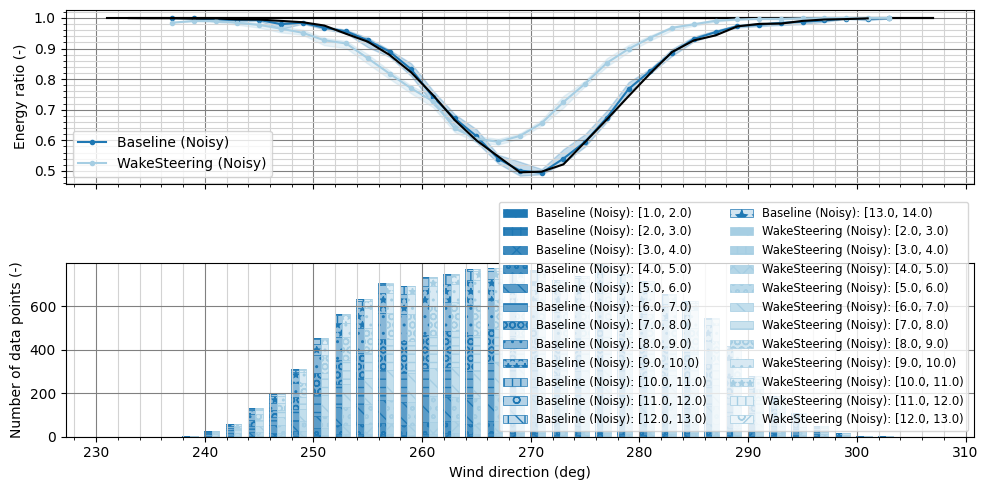

In [13]:
axarr = fsc.plot_energy_ratios(superimpose=True)

ax = axarr[0]
ax.plot(df_erb['wd_bin'], df_erb['baseline'], color='k')

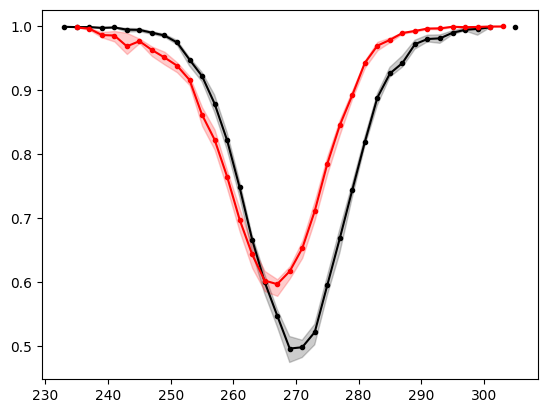

In [14]:
fig ,ax = plt.subplots()

ax.plot(df_erb['wd_bin'], df_erb['baseline'],'.-', color='k')
ax.fill_between(df_erb['wd_bin'], df_erb['baseline_lb'], df_erb['baseline_ub'], color='k', alpha=0.2)

ax.plot(df_erb['wd_bin'], df_erb['wakesteering'], '.-', color='r')
ax.fill_between(df_erb['wd_bin'], df_erb['wakesteering_lb'], df_erb['wakesteering_ub'], color='r', alpha=0.2)

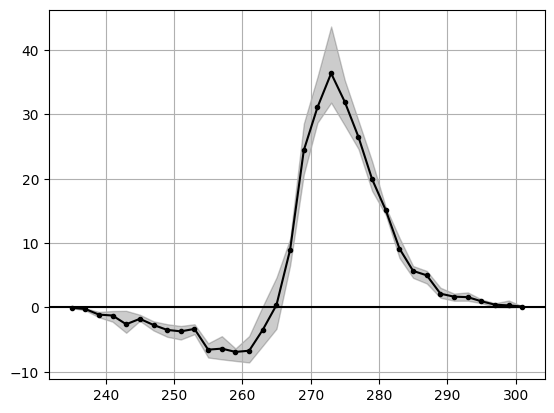

In [15]:
fig ,ax = plt.subplots()

ax.plot(df_erb['wd_bin'], df_erb['uplift'],'.-', color='k')
ax.fill_between(df_erb['wd_bin'], df_erb['uplift_lb'], df_erb['uplift_ub'], color='k', alpha=0.2)
ax.grid(True)
ax.axhline(0, color='k')


## Test out simley approach to calculating energy ratio uplift in regions

In [16]:

erp.compute_uplift_in_region(df_energy, [0], [2], df_names=['baseline', 'wakesteering'])

AttributeError: 'ExprArrayNameSpace' object has no attribute 'mean'

In [ ]:

erp.compute_uplift_in_region_bootstrap(df_energy, [0], [2], df_names=['baseline', 'wakesteering'], N=20)

delta_energy_exp,delta_energy_ub,delta_energy_lb,base_test_energy_exp,base_test_energy_ub,base_test_energy_lb,uplift_exp,uplift_ub,uplift_lb
f64,f64,f64,f64,f64,f64,f64,f64,f64
375440.434934,515533.546932,279230.678002,9.8038e6,1.3947e7,6.8067e6,3.829532,4.204075,3.677621
